In [1]:
import csv
import cv2
import numpy as np
import os

def process_files():
    lines = []
    with open('./data/driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        next(reader, None)
        for line in reader:
            lines.append(line)

    images = []
    measurements = []
    for line in lines:
        for line in lines:
            source_path = line[0]
            filename = source_path.split('/')[-1]
            current_path = './data/IMG/' + filename
            image = cv2.imread(current_path)
            images.append(image)
            measurement = float(line[3])
            measurements.append(measurement)

    X_train = np.array(images)
    y_train = np.array(measurements)

# process_files()

In [2]:
# np.save('trial_X', X_train)
# np.save('trial_y', y_train)

In [3]:
X_train = np.load('trial_X.npy')
y_train = np.load('trial_y.npy')

In [4]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Lambda, ELU
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

Using TensorFlow backend.


In [5]:
def model_1():
    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape = (160, 320, 3)))
    model.add(Flatten())
    model.add(Dense(1))

    model.compile(loss = 'mse', optimizer = 'adam')
    model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, nb_epoch = 7)

    model.save('model_1.h5')

In [6]:
# model_1()

In [7]:
def model_nvidia():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape = (160,320,3)))
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode = "valid", init = 'he_normal'))
    model.add(ELU())
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode = "valid", init = 'he_normal'))
    model.add(ELU())
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode = "valid", init = 'he_normal'))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode = "valid", init = 'he_normal'))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode = "valid", init = 'he_normal'))
    model.add(ELU())
    model.add(Flatten())
    model.add(Dense(1164, init='he_normal'))
    model.add(ELU())
    model.add(Dense(100, init='he_normal'))
    model.add(ELU())
    model.add(Dense(50, init='he_normal'))
    model.add(ELU())
    model.add(Dense(10, init='he_normal'))
    model.add(ELU())
    model.add(Dense(1, init='he_normal'))
    
    model.compile(loss = 'mse', optimizer = 'adam')
    model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, nb_epoch = 7)

    model.save('model_nvidia.h5')

In [8]:
# model_nvidia()

In [9]:
import pandas as pd

data = pd.read_csv('./data/driving_log.csv')


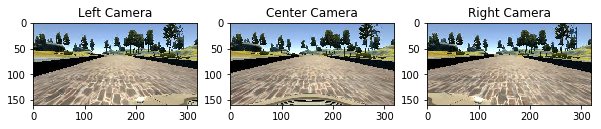

In [10]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

def convert_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def read_image(path):
    return cv2.imread('data/' + path)

img_left = read_image(data['left'][0].strip())
img_center = read_image(data['center'][0].strip())
img_right = read_image(data['right'][0].strip())

import os

# print (data['left'][0].strip())
# print(data['center'][0])
# print(data['right'][0])

plt.figure(figsize=(10,4))

plt.subplot(131)
plt.imshow(convert_rgb(img_left))
plt.title('Left Camera')

plt.subplot(132)
plt.imshow(convert_rgb(img_center))
plt.title('Center Camera')

plt.subplot(133)
plt.imshow(convert_rgb(img_right))
plt.title('Right Camera')

plt.show()





In [11]:
data.head()
# print(len(data))

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


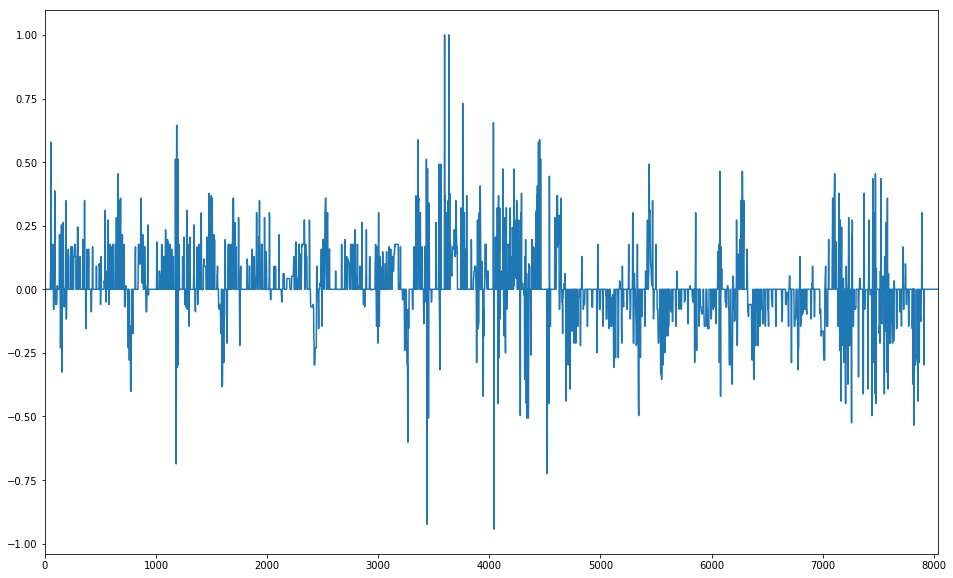

In [12]:
plt.figure(figsize=(16,10))
data['steering'].plot()
plt.show()

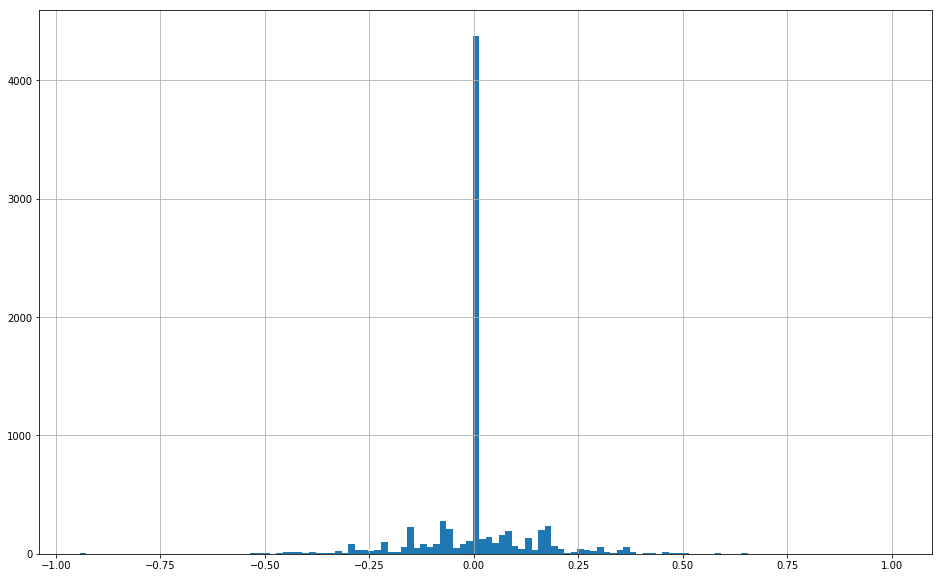

In [13]:
plt.figure(figsize=(16,10))
data['steering'].hist(bins = len(np.unique(data['steering'])))
plt.show()

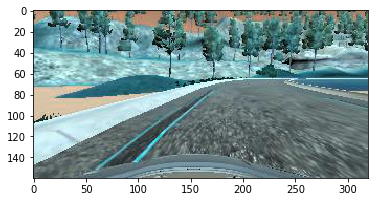

1.0
-1.0


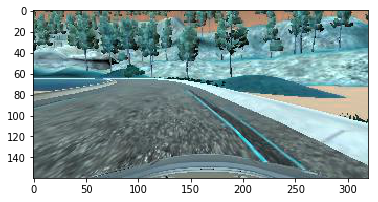

In [14]:
def flip_img(img):
    return np.fliplr(img)

def flip_angle(angle):
    return -angle

img = X_train[3598]
raw_img = img
img_flipped = flip_img(img)
ang = data['steering'][3598]
ang_flipped = flip_angle(ang)
plt.imshow(img)
plt.show()
print(ang)
plt.imshow(img_flipped)
plt.show
print(ang_flipped)

In [15]:
print (next((x, i) for x, i in enumerate(data['steering']) if i >= 0.7))

(3598, 1.0)


In [16]:
print ([(x, i) for x, i in enumerate(data['steering']) if i >= 0.8][0])

(3598, 1.0)


In [17]:
def crop_img(img):
    return img[50:140, : ]

def resize_img(img):
    return cv2.resize(img, (64, 64))

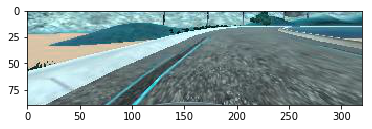

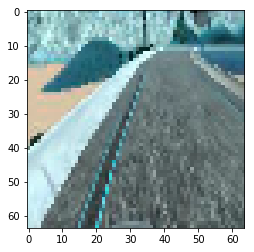

In [18]:
plt.imshow(crop_img(img))
plt.show()
plt.imshow(resize_img(crop_img(img)))
plt.show()

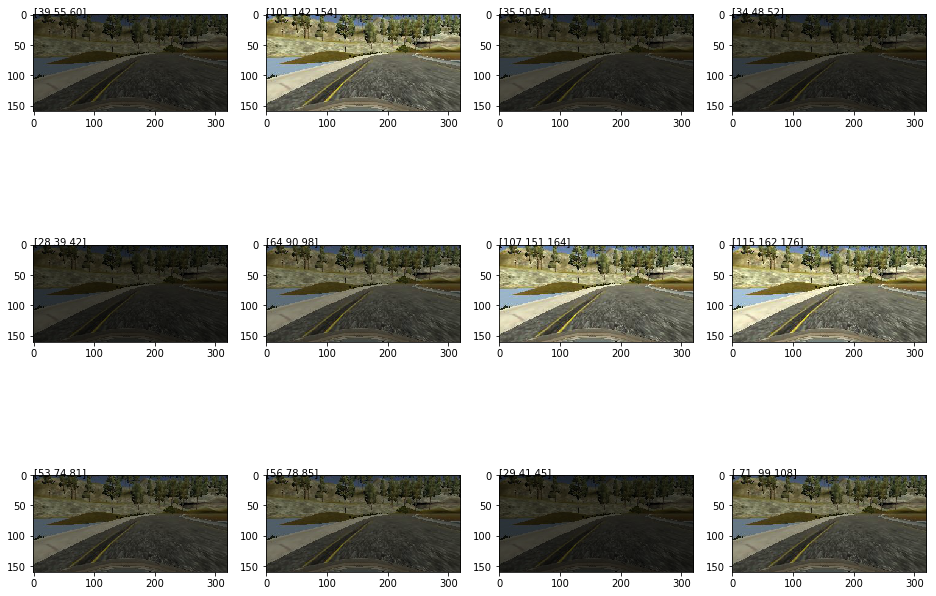

In [19]:

def random_contrast(img):
    img_temp = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_temp[:,:,2] = img_temp[:,:,2] * np.random.uniform(.2, 1.)
    img_temp = cv2.cvtColor(img_temp, cv2.COLOR_HSV2BGR)
    return img_temp

plt.figure(figsize=(16,12))
for i in range(12):
    plt.subplot(3, 4, i+1)
    temp = convert_rgb(random_contrast(raw_img))
    plt.imshow(temp)
    plt.text(0,0, temp[0][0])

plt.show()

In [20]:
yolo = np.random.randint(3)
print (yolo)

1


(160, 320, 3)


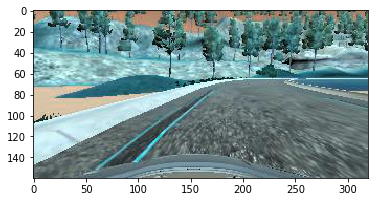

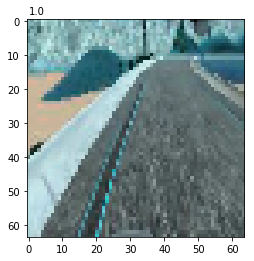

In [21]:
print(raw_img.shape)
plt.imshow(raw_img)
plt.show()

import random

def select_camera(path):
    camera_selection = [0, 1, 2]
    camera_choice = random.choice(camera_selection)
    if camera_choice == 0:
        camera_file = path['left']
        ang = path['steering'] + 0.2
    elif camera_choice == 1:
        camera_file = path['center']
        ang = path['steering']
    elif camera_choice == 2:
        camera_file = path['right']
        ang = path['steering'] - 0.2
        
    return camera_file, ang
    
def preprocess_train(img, ang):
    img = crop_img(img)
    img = resize_img(img)
    img = random_contrast(img)
    flip_choice = random.choice([0, 1])
    if flip_choice == 1:
        img = flip_img(img)
        ang = flip_angle(ang)
    return img, ang

def preprocess_valid(img, ang):
    img = crop_img(img)
    img = resize_img(img)
    img = random_contrast(img)
    flip_choice = random.choice([0, 1])
    if flip_choice == 1:
        img = flip_img(img)
        ang = flip_angle(ang)
    return img, ang

processed_img = preprocess_train(raw_img, ang)

plt.imshow(processed_img[0])
plt.text(0,-2,processed_img[1])

In [22]:
print(data.iloc[0]['center'])
print (len(data))

IMG/center_2016_12_01_13_30_48_287.jpg
8036


In [76]:
def train_pipe(path, batch_size = 100):
    csv_data = pd.read_csv(path + '/driving_log.csv')
    
    batch_images = np.zeros((batch_size, 64, 64, 3))
    batch_angles = np.zeros(batch_size)
    while True:
        for i in range(batch_size):
            line_loc = np.random.randint(0, len(csv_data))
            line_data = csv_data.iloc[line_loc]
            image_file, angle = select_camera(line_data)
            image = cv2.imread(path + '/' + image_file.strip())

            image, angle = preprocess_train(image, angle)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            batch_images[i] = image
            batch_angles[i] = angle

        yield batch_images, batch_angles
            
generate_batch = train_pipe('data')    

def valid_pipe(path):
    csv_data = pd.read_csv(path + '/driving_log.csv')
    
    while True:
        for i in range(len(csv_data)):
            line_data = csv_data.iloc[i]
            image_path = line_data['center'].strip()
            image = cv2.imread(path + '/' + image_path)
            angle = line_data['steering']
            
            image, angle = preprocess_train(image, angle)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            image = image.reshape(1, 64, 64, 3)
            angle = np.array([[angle]])
            yield image, angle
            
generate_valid = valid_pipe('data')

In [77]:
print (max(next(generate_batch)[1]))

0.5009732


In [78]:
print (next(generate_valid)[0].shape)
print (len(next(generate_valid)[0]))
print (next(generate_valid)[1])

(1, 64, 64, 3)
1
[[ 0.]]


In [79]:
def model_2():
    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape = (64, 64, 3)))
    model.add(Flatten())
    model.add(Dense(1))

    model.compile(loss = 'mse', optimizer = 'adam')
#     model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, nb_epoch = 7)
    model.fit_generator(generate_batch, samples_per_epoch = 8000, nb_epoch = 5, validation_data = generate_valid, nb_val_samples = len(data))
    model.save('model_2.h5')

In [80]:
model_2()

Epoch 1/5
8000/8000 [==============================] - 34s - loss: 0.1893 - val_loss: 0.0297
Epoch 2/5
8000/8000 [==============================] - 30s - loss: 0.0390 - val_loss: 0.0220
Epoch 3/5
8000/8000 [==============================] - 32s - loss: 0.0340 - val_loss: 0.0200
Epoch 4/5
8000/8000 [==============================] - 33s - loss: 0.0293 - val_loss: 0.0291
Epoch 5/5
8000/8000 [==============================] - 30s - loss: 0.0305 - val_loss: 0.0189
